# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%pip list

In [3]:
import sys, os
module_path = "."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [4]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [6]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 4096,
        "stop_sequences": ["\n\nHuman"],
        "temperature": 0,
        "top_k": 0,
        "top_p": 0.0
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f0af419a3e0>], client=<botocore.client.BedrockRuntime object at 0x7f0acb977100>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 4096, 'stop_sequences': ['\n\nHuman'], 'temperature': 0, 'top_k': 0, 'top_p': 0.0}, streaming=True)

### Embedding 모델 선택

In [8]:
from langchain.embeddings import BedrockEmbeddings

In [9]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024 # Titan Embedding V1인 경우 1536 , Titan Embedding V2인 경우 1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed) - Optional

In [10]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


리랭커 모델을 사용하려면 deploy = True 로 변경하고 실행 합니다. <br>
SageMaker Endpoint 로 리랭커 모델이 가동됩니다. (켜둔 만큼 비용 발생)

In [13]:
depoly = False

In [14]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [15]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [16]:
from utils.ssm import parameter_store

In [17]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [18]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f0a7a170910>


In [19]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [20]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [21]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [22]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 13.5 ms, sys: 345 μs, total: 13.8 ms
Wall time: 92.1 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [23]:
import boto3
from utils.ssm import parameter_store

In [24]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [25]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [26]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [27]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: complex-doc-index-21


### OpenSearch Client 생성

In [28]:
from utils.opensearch import opensearch_utils

In [29]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [30]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [31]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    hybrid_search_debugger="None", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=False, # enable parent document
    
    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    #rag_fusion=True, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [32]:
system_prompt = prompt_repo.get_system_prompt()

In [33]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

제시된 이미지와 문맥을 통해 중국의 철강 수출 현황을 다음과 같이 파악할 수 있습니다.

중국 세관 데이터에 따르면 2022년 5월 중국의 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 2022년 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. 

그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다. 이는 중국 내 건설 및 인프라 프로젝트 둔화와 관련이 있을 것으로 추정됩니다.

향후 전망으로는 2023년 3월과 10월에 철강 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 예상됩니다.
-----------------------------------------------
1. Category: Image, Chunk: 180 Characters
-----------------------------------------------


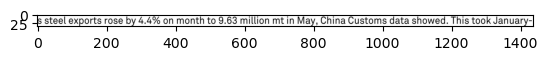

제시된 이미지는 중국의 5월 철강 수출량에 대한 통계 데이터를 보여주고 있습니다. 중국 세관 데이터에 따르면 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을
기록했으며, 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. 이 차트는 중국의 철강 수출 동향을 한눈에 파악할 수 있게 해줍니다.
metadata:
 {'img_path': './fig/figure-5-192.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'a4edfaf4-e154-4657-aec1-f2af8e3352c9', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 186 Characters
-----------------------------------------------


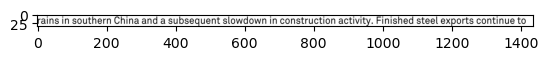

이미지는 중국 남부 지역의 강우와 건설 활동 둔화로 인한 철강 수출 감소 추이를 보여주는 그래프입니다. 2022년 상반기에 철강 수출량이 크게 감소한 것을 알 수 있습니다. 이는
중국 내 건설 및 인프라 프로젝트 둔화와 관련이 있을 것으로 보입니다. 그래프를 통해 중국 경제 상황과 글로벌 공급망에 미치는 영향을 가늠할 수 있습니다.
metadata:
 {'img_path': './fig/figure-4-147.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '9868d9d0-806c-433a-8abc-ac9795ed1c06', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 233 Characters
-----------------------------------------------


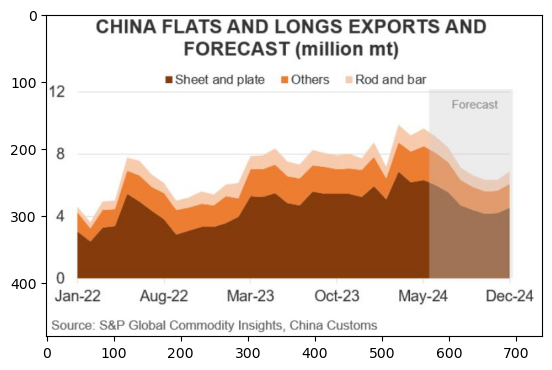

이 이미지는 중국의 평철과 장강재 수출 및 예측치를 보여주는 그래프입니다. 가로축은 2022년 1월부터 2024년 12월까지의 기간을 나타내며, 세로축은 백만 메트릭톤 단위로
수출량을 표시합니다. 주황색 막대는 평철과 봉강재 수출량을, 갈색 막대는 기타 제품의 수출량을 나타냅니다. 그래프를 보면 2023년 3월과 10월에 수출량이 감소하는 모습을 볼 수
있으며, 2024년에는 다시 증가할 것으로 예측되고 있습니다.
metadata:
 {'img_path': './fig/figure-5-204.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'bf271ad2-18be-4345-83a1-e13c43d730fe', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 168 Characters
-----------------------------------------------


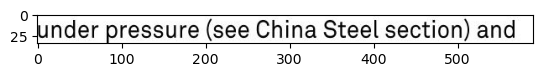

이 이미지는 중국 철강 산업에 대한 기사 제목과 본문의 일부분을 보여주고 있습니다. 제목은 "중국 철강 부문을 참조하십시오"라고 언급하고 있으며, 본문에서는 중국 철강 산업이
압박을 받고 있다는 내용을 다루고 있습니다. 이 기사는 중국 철강 산업의 현황과 어려움에 대해 설명하고 있는 것으로 보입니다.
metadata:
 {'img_path': './fig/figure-8-273.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '79c5309a-ca76-41e0-9690-9270010d8fa0', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 217 Characters
-----------------------------------------------


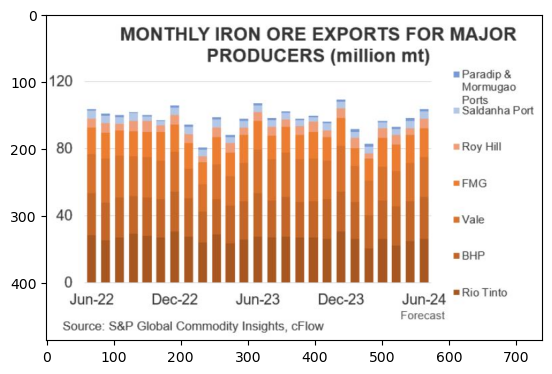

이 이미지는 주요 철광석 생산업체들의 월간 철광석 수출량을 보여주는 차트입니다. 차트는 2022년 6월부터 2024년 6월까지의 예측치를 포함하고 있습니다. 파라딥 및 모르무가오
항구, 살다나 항구, 로이힐, FMG, 발레, BHP, 리오틴토 등의 업체별 수출량이 막대그래프로 표시되어 있습니다. 전반적으로 파라딥 및 모르무가오 항구와 살다나 항구의 수출량이
가장 높은 것으로 나타납니다.
metadata:
 {'img_path': './fig/figure-10-412.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '20e74d06-48ab-4f77-a32c-181c1c4b0c06', 'origin_image': '',
'orig_elements': ''}


In [34]:
query = "중국의 철강 수출 현황을 알려줘."

response, contexts = qa.invoke(
    query=query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [35]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger="None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    
    rag_fusion=False, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    
    hyde=False, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    
    parent_document=False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [36]:
query = "중국의 철강 수출 현황을 알려줘." # for table

In [37]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

제시된 이미지와 텍스트를 종합해보면, 중국의 철강 수출 현황은 다음과 같습니다.

중국 세관 데이터에 따르면 2022년 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. 

그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다. 

향후 전망으로는 2023년 3월과 10월에 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다.

한편 중국 정부는 불법 철강 행위에 대한 조사를 실시하겠다고 밝혀, 이에 따라 철강 수출에 압박이 가해질 가능성도 있습니다.

##################################
query:  중국의 철강 수출 현황을 알려줘.
##################################


### Answer ###
제시된 이미지와 텍스트를 종합해보면, 중국의 철강 수출 현황은 다음과 같습니다.

중국 세관 데이터에 따르면 2022년 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에
달했습니다.

그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다.

향후 전망으로는 2023년 3월과 10월에 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다.

한편 중국 정부는 불법 철강 행위에 대한 조사를 실시하겠다고 밝혀, 이에 따라 철강 수출에 압박이 가해질 가능성도 있습니다.


### Contexts ###

-----------------------------------------------
1. Category: Image, Chunk: 180 Characters
-----------------------------------------------


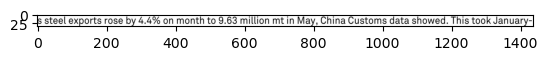

제시된 이미지는 중국의 5월 철강 수출량에 대한 통계 데이터를 보여주고 있습니다. 중국 세관 데이터에 따르면 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을
기록했으며, 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. 이 차트는 중국의 철강 수출 동향을 한눈에 파악할 수 있게 해줍니다.
metadata:
 {'img_path': './fig/figure-5-192.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'a4edfaf4-e154-4657-aec1-f2af8e3352c9', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 186 Characters
-----------------------------------------------


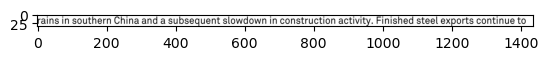

이미지는 중국 남부 지역의 강우와 건설 활동 둔화로 인한 철강 수출 감소 추이를 보여주는 그래프입니다. 2022년 상반기에 철강 수출량이 크게 감소한 것을 알 수 있습니다. 이는
중국 내 건설 및 인프라 프로젝트 둔화와 관련이 있을 것으로 보입니다. 그래프를 통해 중국 경제 상황과 글로벌 공급망에 미치는 영향을 가늠할 수 있습니다.
metadata:
 {'img_path': './fig/figure-4-147.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '9868d9d0-806c-433a-8abc-ac9795ed1c06', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 233 Characters
-----------------------------------------------


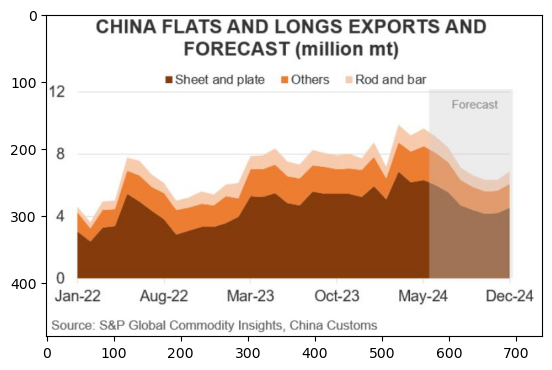

이 이미지는 중국의 평철과 장강재 수출 및 예측치를 보여주는 그래프입니다. 가로축은 2022년 1월부터 2024년 12월까지의 기간을 나타내며, 세로축은 백만 메트릭톤 단위로
수출량을 표시합니다. 주황색 막대는 평철과 봉강재 수출량을, 갈색 막대는 기타 제품의 수출량을 나타냅니다. 그래프를 보면 2023년 3월과 10월에 수출량이 감소하는 모습을 볼 수
있으며, 2024년에는 다시 증가할 것으로 예측되고 있습니다.
metadata:
 {'img_path': './fig/figure-5-204.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'bf271ad2-18be-4345-83a1-e13c43d730fe', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 168 Characters
-----------------------------------------------


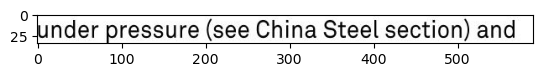

이 이미지는 중국 철강 산업에 대한 기사 제목과 본문의 일부분을 보여주고 있습니다. 제목은 "중국 철강 부문을 참조하십시오"라고 언급하고 있으며, 본문에서는 중국 철강 산업이
압박을 받고 있다는 내용을 다루고 있습니다. 이 기사는 중국 철강 산업의 현황과 어려움에 대해 설명하고 있는 것으로 보입니다.
metadata:
 {'img_path': './fig/figure-8-273.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '79c5309a-ca76-41e0-9690-9270010d8fa0', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 235 Characters
-----------------------------------------------


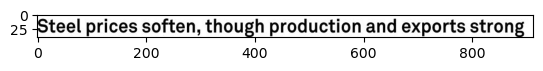

주어진 이미지는 "Steel prices soften, though production and exports strong"이라는 제목을 가지고 있습니다. 이는 철강 가격이
하락했지만 생산과 수출은 여전히 강세를 보이고 있음을 시사합니다. 이미지 자체에는 텍스트 외에 다른 시각적 요소는 없습니다. 간단히 말해, 이 이미지는 철강 산업의 현황, 특히
가격 하락에도 불구하고 생산과 수출이 견조하다는 점을 강조하고 있습니다.
metadata:
 {'img_path': './fig/figure-4-143.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '404db497-5a46-4b1e-a80e-790a4929b6b6', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Category: Image, Chunk: 196 Characters
-----------------------------------------------


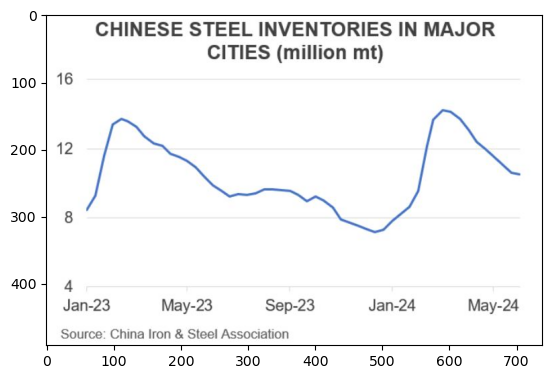

이 이미지는 중국 주요 도시의 철강 재고량 추이를 보여주는 그래프입니다. 2023년 1월부터 2024년 5월까지의 기간 동안 철강 재고량이 등락을 거듭하는 모습을 볼 수 있습니다.
특히 2024년 1월에 재고량이 크게 증가했다가 5월에 다시 감소하는 양상을 보이고 있습니다. 이 그래프를 통해 중국 철강 산업의 수요와 공급 동향을 파악할 수 있습니다.
metadata:
 {'img_path': './fig/figure-7-266.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'c6a892a0-e058-4d4b-b2ab-ec13c0077214', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
7. Category: Image, Chunk: 155 Characters
-----------------------------------------------


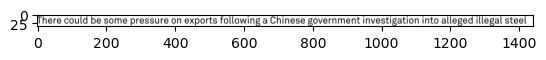

이미지는 중국 정부가 불법 철강 행위에 대한 조사를 실시한다는 내용의 뉴스 기사 제목을 보여주고 있습니다. 이는 중국의 철강 수출에 압박이 가해질 수 있음을 시사합니다. 제목은
간결하고 사실적인 어조로 작성되어 있으며, 배경은 단색으로 되어 있어 내용에 집중할 수 있게 합니다.
metadata:
 {'img_path': './fig/figure-5-199.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '1f7f354f-9ec4-466c-9202-e13a168ecec7', 'origin_image': '',
'orig_elements': ''}


In [38]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

### Multi-turn using chat history

In [39]:
from utils.chat import chat_utils
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

#### Momory setting and Save query and response as chat history

In [40]:
memory = chat_utils.get_memory(
    memory_type="ConversationBufferMemory",
    memory_key="chat_history"
)

history = memory.load_memory_variables({})["chat_history"]

In [41]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [42]:
print('memory: ', history)

memory:  [HumanMessage(content='중국의 철강 수출 현황을 알려줘.'), AIMessage(content='제시된 이미지와 텍스트를 종합해보면, 중국의 철강 수출 현황은 다음과 같습니다.\n\n중국 세관 데이터에 따르면 2022년 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. \n\n그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다. \n\n향후 전망으로는 2023년 3월과 10월에 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다.\n\n한편 중국 정부는 불법 철강 행위에 대한 조사를 실시하겠다고 밝혀, 이에 따라 철강 수출에 압박이 가해질 가능성도 있습니다.')]


#### Rephrase quetions based on chat hostory 

In [43]:
human_prompt = """
               Here is the question: <question>{question}</question>
               Write in Korean.
               """
               
system_prompt = prompt_repo.get_contextualize_system_prompt()
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [44]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        MessagesPlaceholder("chat_history"),
        human_message_template
    ]
)

In [45]:
chain = contextualize_q_prompt | llm_text | StrOutputParser()

In [46]:
#query = "첫 번째 답에서 각 사례, 유형은 뭐가 있어?"
query = "중국의 철강 수출 현황을 알려줘."

history = memory.load_memory_variables({})["chat_history"]
print('memory: ', history)
revised_question = chain.invoke(
    {
        "chat_history": history,
        "question": query,
    }
)
revised_question = revised_question.replace("<result>", "").replace("</result>", "")
print ("=============")
print (f'revised_question: {revised_question}')

memory:  [HumanMessage(content='중국의 철강 수출 현황을 알려줘.'), AIMessage(content='제시된 이미지와 텍스트를 종합해보면, 중국의 철강 수출 현황은 다음과 같습니다.\n\n중국 세관 데이터에 따르면 2022년 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. \n\n그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다. \n\n향후 전망으로는 2023년 3월과 10월에 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다.\n\n한편 중국 정부는 불법 철강 행위에 대한 조사를 실시하겠다고 밝혀, 이에 따라 철강 수출에 압박이 가해질 가능성도 있습니다.')]
<result>중국의 철강 수출량은 어떤 수준이며, 최근 추이와 향후 전망은 어떠한가?</result>=============
revised_question: 중국의 철강 수출량은 어떤 수준이며, 최근 추이와 향후 전망은 어떠한가?


In [47]:
print (f'revised_question: {revised_question}')

revised_question: 중국의 철강 수출량은 어떤 수준이며, 최근 추이와 향후 전망은 어떠한가?


#### Repeat QA and save chat history

In [48]:
response, contexts = qa.invoke(
    query = revised_question,
    verbose=False
)

제시된 이미지와 텍스트에 따르면, 중국의 철강 수출량은 최근 증가세를 보이고 있습니다. 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했으며, 1월부터 5월까지 누적 수출량은 4,830만 톤에 달했습니다. 그러나 2022년 상반기에는 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 바 있습니다. 향후 전망으로는 평철과 봉강재 수출량이 2023년 3월과 10월에 일시적으로 감소할 것으로 예상되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다. 또한 HRC(열연강판) 가격도 상승할 것으로 전망되고 있습니다.

In [49]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [50]:
print('memory: ', history)

memory:  [HumanMessage(content='중국의 철강 수출 현황을 알려줘.'), AIMessage(content='제시된 이미지와 텍스트를 종합해보면, 중국의 철강 수출 현황은 다음과 같습니다.\n\n중국 세관 데이터에 따르면 2022년 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했습니다. 이로써 1월부터 5월까지의 누적 수출량은 4,830만 톤에 달했습니다. \n\n그러나 2022년 상반기에는 중국 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 것으로 보입니다. \n\n향후 전망으로는 2023년 3월과 10월에 수출량이 일시적으로 감소할 것으로 예측되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다.\n\n한편 중국 정부는 불법 철강 행위에 대한 조사를 실시하겠다고 밝혀, 이에 따라 철강 수출에 압박이 가해질 가능성도 있습니다.'), HumanMessage(content='중국의 철강 수출 현황을 알려줘.'), AIMessage(content='제시된 이미지와 텍스트에 따르면, 중국의 철강 수출량은 최근 증가세를 보이고 있습니다. 5월 철강 수출량은 전월 대비 4.4% 증가한 963만 톤을 기록했으며, 1월부터 5월까지 누적 수출량은 4,830만 톤에 달했습니다. 그러나 2022년 상반기에는 남부 지역의 강우와 건설 활동 둔화로 인해 철강 수출량이 크게 감소한 바 있습니다. 향후 전망으로는 평철과 봉강재 수출량이 2023년 3월과 10월에 일시적으로 감소할 것으로 예상되지만, 2024년에는 다시 증가할 것으로 내다보고 있습니다. 또한 HRC(열연강판) 가격도 상승할 것으로 전망되고 있습니다.')]
